## Install `PADL-Extensions`

In [ ]:
!pip install padl-extensions[pytorch_lightning]
!pip install torchvision

In [ ]:
# These might be useful if there are errors regarding ipywidgets while downloading torchvision.datasets
# !pip install ipywidgets
# !jupyter nbextension enable --py widgetsnbextension

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import models

import padl
from padl import transform

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

## Using PADL with Pytorch Lightning

## Dataset:
MNIST dataset available through torchvision is used in this notebook. The dataset can be separately downloaded from MNIST website or can be loaded as given below. 

More details on torchvision's MNIST dataset can be found here: https://pytorch.org/vision/stable/datasets.html#mnist

In [2]:
mnist_train_dataset = torchvision.datasets.MNIST('data', train=True, download=True)
mnist_test_dataset = torchvision.datasets.MNIST('data', train=False, download=True)

## 1. Model Definition

We will build a simple `Unet` to classify `MNIST` handwritings. In the cell below, a simple `torch.nn.Module` is defined with the decorator `@transform`. This is enough to wrap the pytorch model into a `padl.Transform` object.

In [3]:
import torch.nn.functional as F
import torchvision.models.resnet 
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler


@transform
class SimpleNet(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # Conv 1
        # size : input: 28x28x1 -> output : 26 x 26 x 32
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3)
        self.batchnorm1 = torch.nn.BatchNorm2d(32)

        # Conv 2
        # size : input: 26x26x32 -> output : 24 x 24 x 32
        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=3)
        self.batchnorm2 = torch.nn.BatchNorm2d(32)

        # Conv 3
        # size : input: 24x24x32 -> output : 12 x 12 x 32
        self.conv3 = torch.nn.Conv2d(32, 32, kernel_size=2, stride = 2)
        self.batchnorm3 = torch.nn.BatchNorm2d(32)

        # Conv 4
        # size : input : 12 x 12 x 32 -> output : 8 x 8 x 64
        self.conv4 = torch.nn.Conv2d(32, 64, kernel_size=5)
        self.batchnorm4 = torch.nn.BatchNorm2d(64)

        # Conv 5
        # size : input: 8x8x64 -> output : 4 x 4 x 64 -> Linearize = 1024
        self.conv5 = torch.nn.Conv2d(64, 64, kernel_size=2, stride = 2)
        self.batchnorm5 = torch.nn.BatchNorm2d(64)

        # dropout layer 
        self.conv5_drop = torch.nn.Dropout2d()

        # FC 1 
        self.fc1 = torch.nn.Linear(1024, 128)

        # FC 2
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.batchnorm3(F.relu(self.conv3(x)))
        x = self.batchnorm4(F.relu(self.conv4(x)))
        x = self.batchnorm5(F.relu(self.conv5(x)))
        x = self.conv5_drop(x)
        x = x.view(-1, 1024)
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), dim=1)
        return x

In [4]:
@transform
def convert_to_tensor(img):
    arr = np.asarray(img)
    return torch.tensor(arr).type(torch.FloatTensor)

preprocess = (
    convert_to_tensor / convert_to_tensor
    >> padl.same.reshape(-1, 28, 28) / padl.Identity()
)

simplenet = SimpleNet()
loss_func = transform(F.nll_loss)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device to be used: ', device)

Device to be used:  cpu


In [6]:
train_model = (
    preprocess
    >> padl.Batchify()
    >> simplenet / padl.same.type(torch.long)
    >> transform(F.nll_loss)
)

train_model.pd_to(device)

Compose - "train_model":

      │└────────────────────┐
      │                     │
      ▼ img                 ▼ img
   0: convert_to_tensor   / convert_to_tensor
      │                     │
      ▼ args                ▼ args
   1: reshape(-1, 28, 28) / Identity()       
      │
      ▼ args
   2: Batchify(dim=0)    
      │└────────────────────┐
      │                     │
      ▼ x                   ▼ args
   3: SimpleNet()         / type(torch.int64)
      │
      ▼ (input, target, weight, size_average, ignore_index, reduce, reduction)
   4: nll_loss           

In [7]:
infer_preprocess =(
    padl.same[0]
    >> convert_to_tensor
)
infer_model = (
    infer_preprocess
    >> padl.Batchify()
    >> padl.same.unsqueeze(1) 
    >> simplenet
    >> padl.transform(lambda x: x.max(1).indices)
)
infer_model

Compose - "infer_model":

      │
      ▼ args
   0: __getitem__(0)            
      │
      ▼ img
   1: convert_to_tensor         
      │
      ▼ args
   2: Batchify(dim=0)           
      │
      ▼ args
   3: unsqueeze(1)              
      │
      ▼ x
   4: SimpleNet()               
      │
      ▼ x
   5: lambda x: x.max(1).indices

## 2. Converting a PADL model into a Lightning Module

In [12]:
from padl_ext.pytorch_lightning import DefaultPadlLightning

## 2.1 Use the DefaultPadlLightning class
If your `train_model` has the loss function as the final step you can initialize the `DefaultPadlLightning` object by

In [11]:
DefaultPadlLightning?

In [40]:
batch_size = 256
num_workers = 4

padl_lightning_module = DefaultPadlLightning(
    train_model,  # train_model with the loss function
    learning_rate=1e-3,
    train_data=mnist_train_dataset,  # list of training data points
    val_data=mnist_test_dataset,  # list of validation data points
    batch_size=batch_size,
    num_workers=num_workers
)
# pad_lightning is a LightningModule !

### Model Training

In [41]:
log_interval = 10
nepoch = 1

trainer = pl.Trainer(
    gpus=1 if device == 'cuda' else 0,
    val_check_interval=10,
    max_epochs=nepoch,
    default_root_dir='test',
    log_every_n_steps=log_interval
)
trainer.fit(padl_lightning_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name      | Type      | Params
----------------------------------------
0 | SimpleNet | SimpleNet | 214 K 
----------------------------------------
214 K     Trainable params
0         Non-trainable params
214 K     Total params
0.857     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

saving torch module to test/lightning_logs/version_10/checkpoints/epoch=0-step=9.padl/8.pt


Validating: 0it [00:00, ?it/s]

saving torch module to test/lightning_logs/version_10/checkpoints/epoch=0-step=19.padl/8.pt


In [42]:
trainer.callbacks

## 2.2 Inherit from BasePadlLightning
The class `BasePadlLightning` is already a `LightningModule` so inherting from it allows for all the regular customizations available in Pytorch Lightning

In [27]:
from padl_ext.pytorch_lightning import BasePadlLightning, OnCheckpointSavePadl

In [ ]:
BasePadlLightning?

In [28]:
class MyModule(BasePadlLightning):
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [29]:
batch_size = 256
num_workers = 0

padl_lightning_module = MyModule(
    train_model,  # train_model with the loss function
    train_data=mnist_train_dataset,  # list of training data points
    val_data=mnist_test_dataset,  # list of validation data points
    batch_size=batch_size,
    num_workers=num_workers
)
# pad_lightning is a LightningModule !

### Model Training

In [47]:
log_interval = 10
nepoch = 1

early_stop = EarlyStopping(monitor="val_loss", mode="min")
# model_checkpoint = ModelCheckpoint(monitor="val_loss", every_n_epochs=1, save_top_k=1)
model_checkpoint = ModelCheckpoint(monitor="val_loss")
callbacks = [early_stop, model_checkpoint, OnCheckpointSavePadl()]
# callbacks = [OnCheckpointSavePadl()]

trainer = pl.Trainer(
    callbacks=callbacks,
    gpus=1 if device == 'cuda' else 0,
    val_check_interval=10,
    max_epochs=nepoch,
    default_root_dir='test',
    log_every_n_steps=log_interval
)
trainer.fit(padl_lightning_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type      | Params
----------------------------------------
0 | SimpleNet | SimpleNet | 214 K 
----------------------------------------
214 K     Trainable params
0         Non-trainable params
214 K     Total params
0.857     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

saving torch module to test/lightning_logs/version_12/checkpoints/epoch=0-step=9.padl/8.pt


Validating: 0it [00:00, ?it/s]

saving torch module to test/lightning_logs/version_12/checkpoints/epoch=0-step=19.padl/8.pt


Validating: 0it [00:00, ?it/s]

saving torch module to test/lightning_logs/version_12/checkpoints/epoch=0-step=29.padl/8.pt


Validating: 0it [00:00, ?it/s]

saving torch module to test/lightning_logs/version_12/checkpoints/epoch=0-step=39.padl/8.pt


Validating: 0it [00:00, ?it/s]

saving torch module to test/lightning_logs/version_12/checkpoints/epoch=0-step=49.padl/8.pt


Validating: 0it [00:00, ?it/s]

## 4. Infer a few images from the test data

In [22]:
@transform
def plot_image(img_tensor):
    fig= plt.figure(figsize=(2,2))
    ax = fig.add_subplot(111)
    ax.imshow(img_tensor, cmap='gray')
    plt.axis('off')
    return fig

@transform
def img_to_array(img):
    return np.asarray(img)

convert_plot = (
    img_to_array
    >> plot_image
)

plot_datapoint = (convert_plot - 'image')/ (padl.Identity() - 'label')

In [ ]:
for _ in range(5):
    data_point = mnist_test_dataset[np.random.randint(len(mnist_test_dataset))]
    output = plot_datapoint(data_point)
    plt.show()
    print(f'Prediction: {infer_model.infer_apply(data_point).item()}')
    print('-'*30)

## Testing

In [13]:
from padl import load

In [14]:
test = load('test/lightning_logs/version_12/checkpoints/epoch=0-step=49.padl/')

loading torch module from test/lightning_logs/version_12/checkpoints/epoch=0-step=49.padl/8.pt


In [20]:
test[3][0].pd_name

'simplenet'

In [24]:
infer_preprocess =(
    padl.same[0]
    >> convert_to_tensor
)
trained_net = test[3][0]
infer_model = (
    infer_preprocess
    >> padl.Batchify()
    >> padl.same.unsqueeze(1) 
    >> trained_net
    >> padl.transform(lambda x: x.max(1).indices)
)

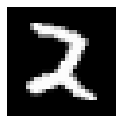

Prediction: 2
------------------------------


[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


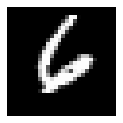

Prediction: 6
------------------------------


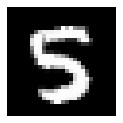

Prediction: 5
------------------------------


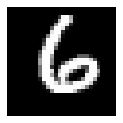

Prediction: 6
------------------------------


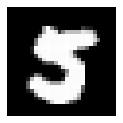

Prediction: 5
------------------------------


In [23]:
for _ in range(5):
    data_point = mnist_test_dataset[np.random.randint(len(mnist_test_dataset))]
    output = plot_datapoint(data_point)
    plt.show()
    print(f'Prediction: {infer_model.infer_apply(data_point).item()}')
    print('-'*30)

## Reloading Pytorch Lightning Checkpoint

In [40]:
path = 'test/lightning_logs/version_12/checkpoints/epoch=0-step=49'
loaded_padl_model = load(path + '.padl/')
pl_module = MyModule.load_from_checkpoint(path + '.ckpt')

loading torch module from test/lightning_logs/version_12/checkpoints/epoch=0-step=49.padl/8.pt


TypeError: __init__() missing 2 required positional arguments: 'padl_model' and 'train_data'